# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [44]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [45]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

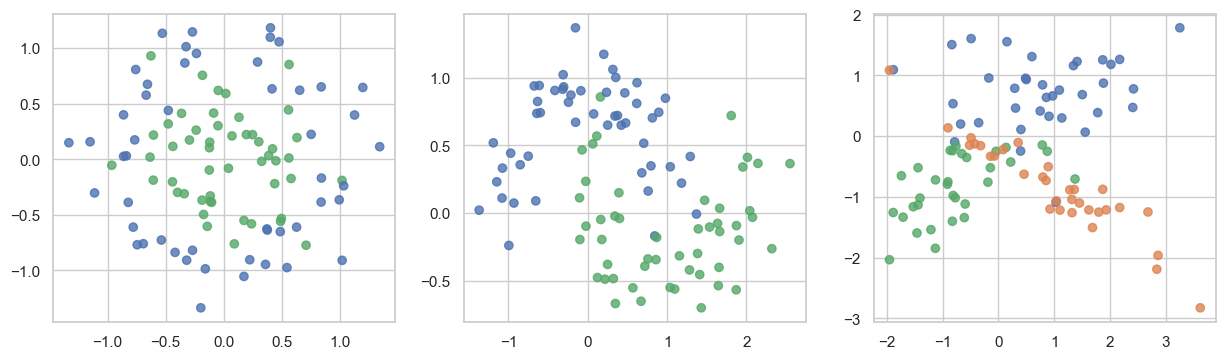

In [46]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [47]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

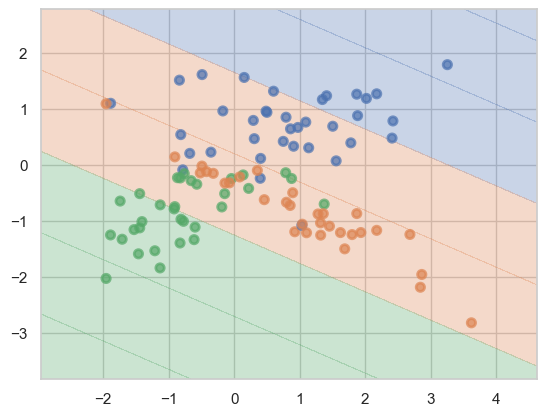

In [48]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1: train_accuracy = 1.000, test_accuracy = 0.733, overfitting = 0.267
Dataset 2: train_accuracy = 1.000, test_accuracy = 0.867, overfitting = 0.133
Dataset 3: train_accuracy = 1.000, test_accuracy = 0.833, overfitting = 0.167


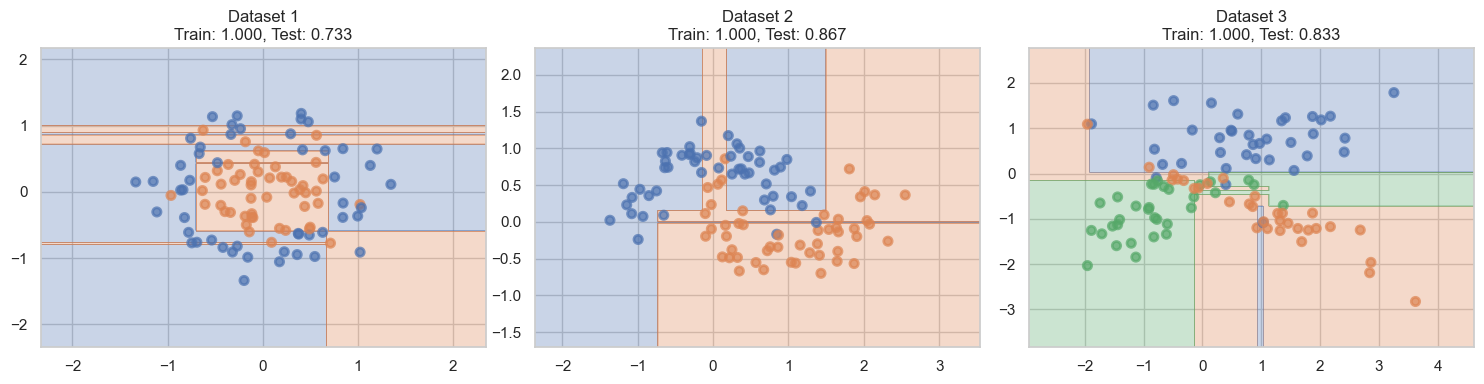

In [49]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 4))

for i, (X, y) in enumerate(datasets, start=1):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, 
    )
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(
        f"Dataset {i}: train_accuracy = {train_acc:.3f}, "
        f"test_accuracy = {test_acc:.3f}, "
        f"overfitting = {train_acc - test_acc:.3f}"
    )

    plt.subplot(1, 3, i)
    plot_surface(clf, X, y)
    plt.title(f"Dataset {i}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}")

plt.tight_layout()
plt.show()

__Ответ:__

Все деревья переобучились (train accuracy = 1.000)

Степень переобучения варьируется от умеренной до сильной

Наиболее сильно переобучение проявилось на Dataset 3 и Dataset 1

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


ДАТАСЕТ 1
Параметры: max_depth=None, min_samples_leaf=1
  Train accuracy: 1.000, Test accuracy: 0.733, Overfitting: 0.267
Параметры: max_depth=3, min_samples_leaf=1
  Train accuracy: 0.886, Test accuracy: 0.733, Overfitting: 0.152
Параметры: max_depth=5, min_samples_leaf=1
  Train accuracy: 0.971, Test accuracy: 0.767, Overfitting: 0.205
Параметры: max_depth=None, min_samples_leaf=5
  Train accuracy: 0.871, Test accuracy: 0.900, Overfitting: -0.029
Параметры: max_depth=None, min_samples_leaf=10
  Train accuracy: 0.814, Test accuracy: 0.767, Overfitting: 0.048
Параметры: max_depth=5, min_samples_leaf=5
  Train accuracy: 0.871, Test accuracy: 0.900, Overfitting: -0.029


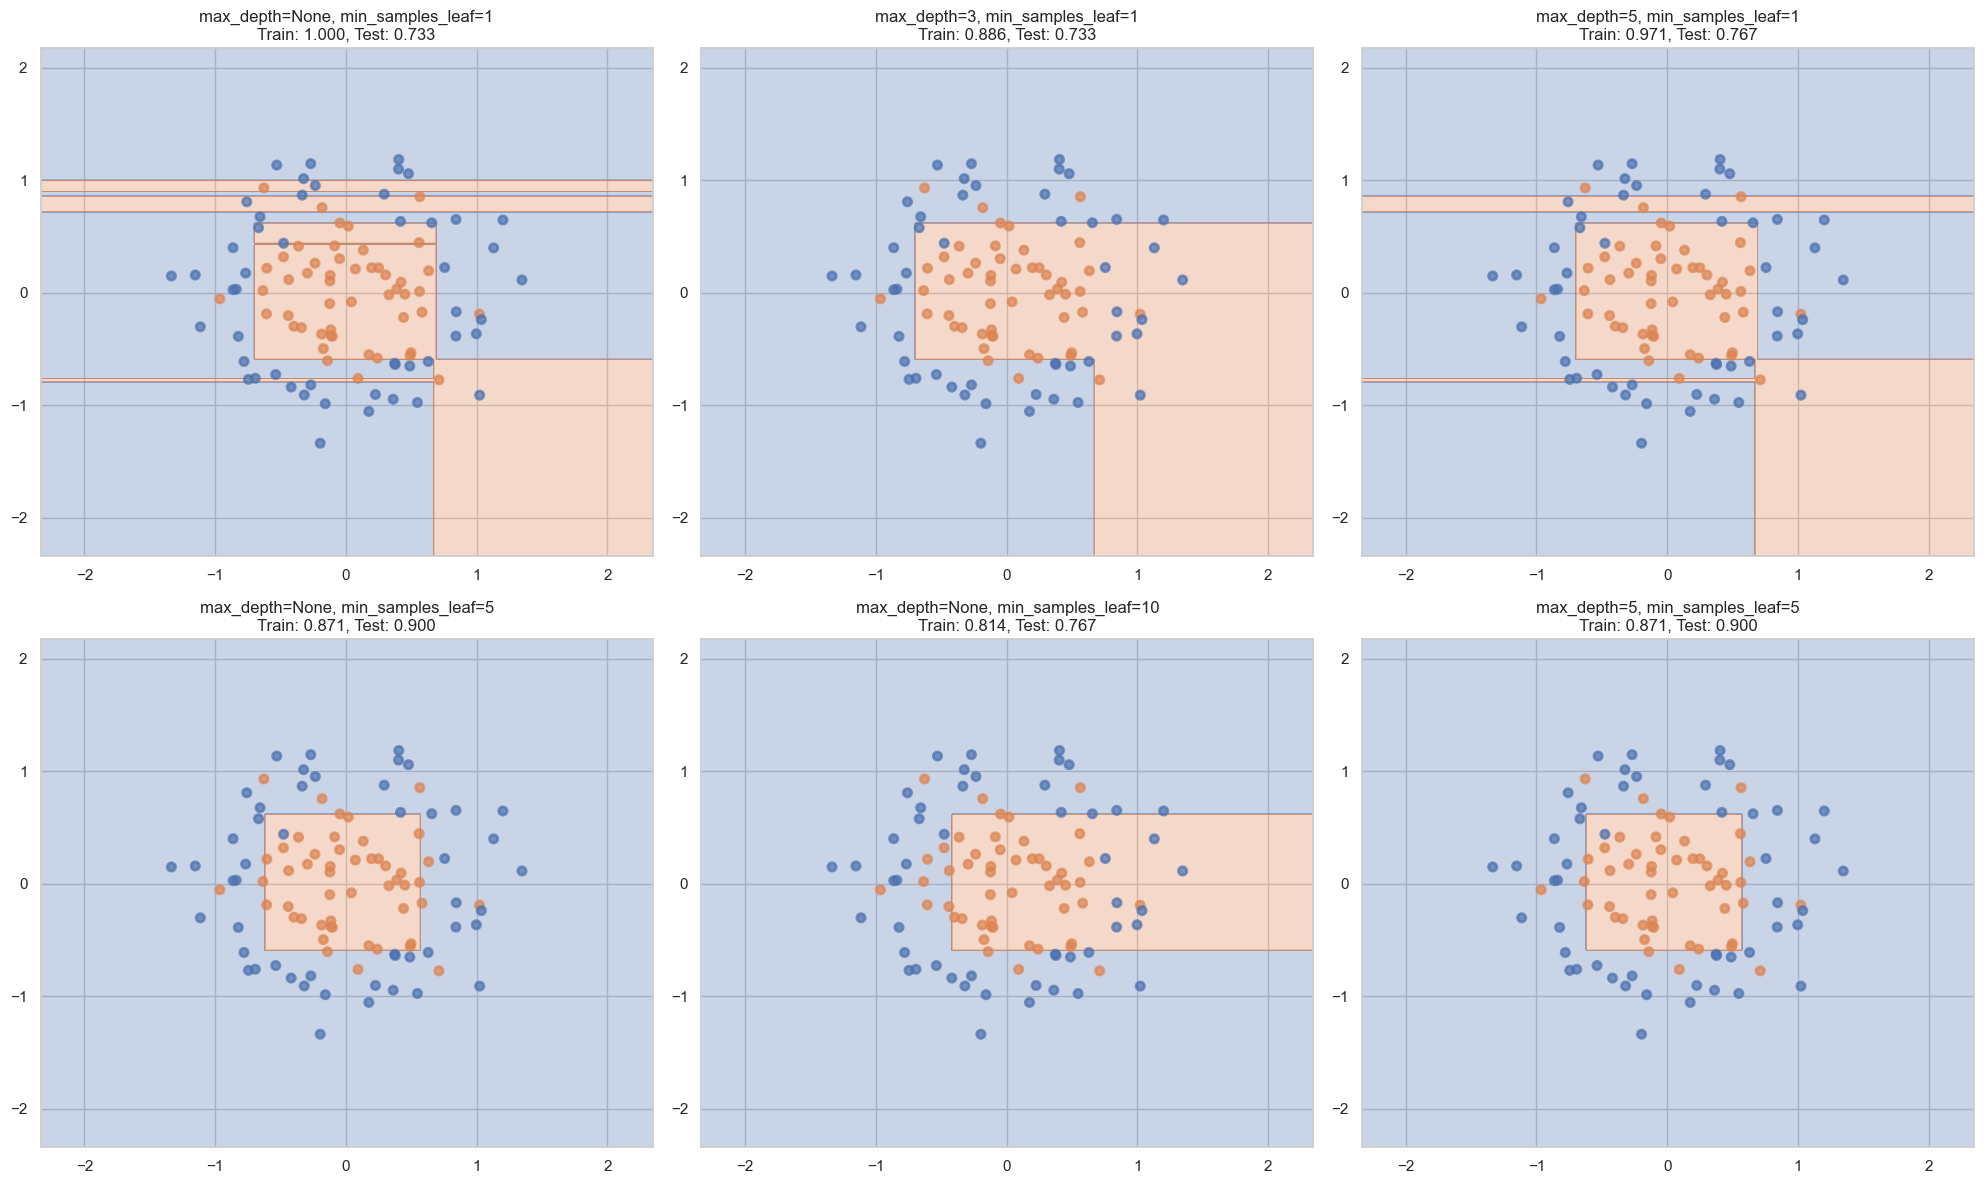


ДАТАСЕТ 2
Параметры: max_depth=None, min_samples_leaf=1
  Train accuracy: 1.000, Test accuracy: 0.867, Overfitting: 0.133
Параметры: max_depth=3, min_samples_leaf=1
  Train accuracy: 0.914, Test accuracy: 0.933, Overfitting: -0.019
Параметры: max_depth=5, min_samples_leaf=1
  Train accuracy: 1.000, Test accuracy: 0.867, Overfitting: 0.133
Параметры: max_depth=None, min_samples_leaf=5
  Train accuracy: 0.957, Test accuracy: 0.733, Overfitting: 0.224
Параметры: max_depth=None, min_samples_leaf=10
  Train accuracy: 0.871, Test accuracy: 0.767, Overfitting: 0.105
Параметры: max_depth=5, min_samples_leaf=5
  Train accuracy: 0.957, Test accuracy: 0.733, Overfitting: 0.224


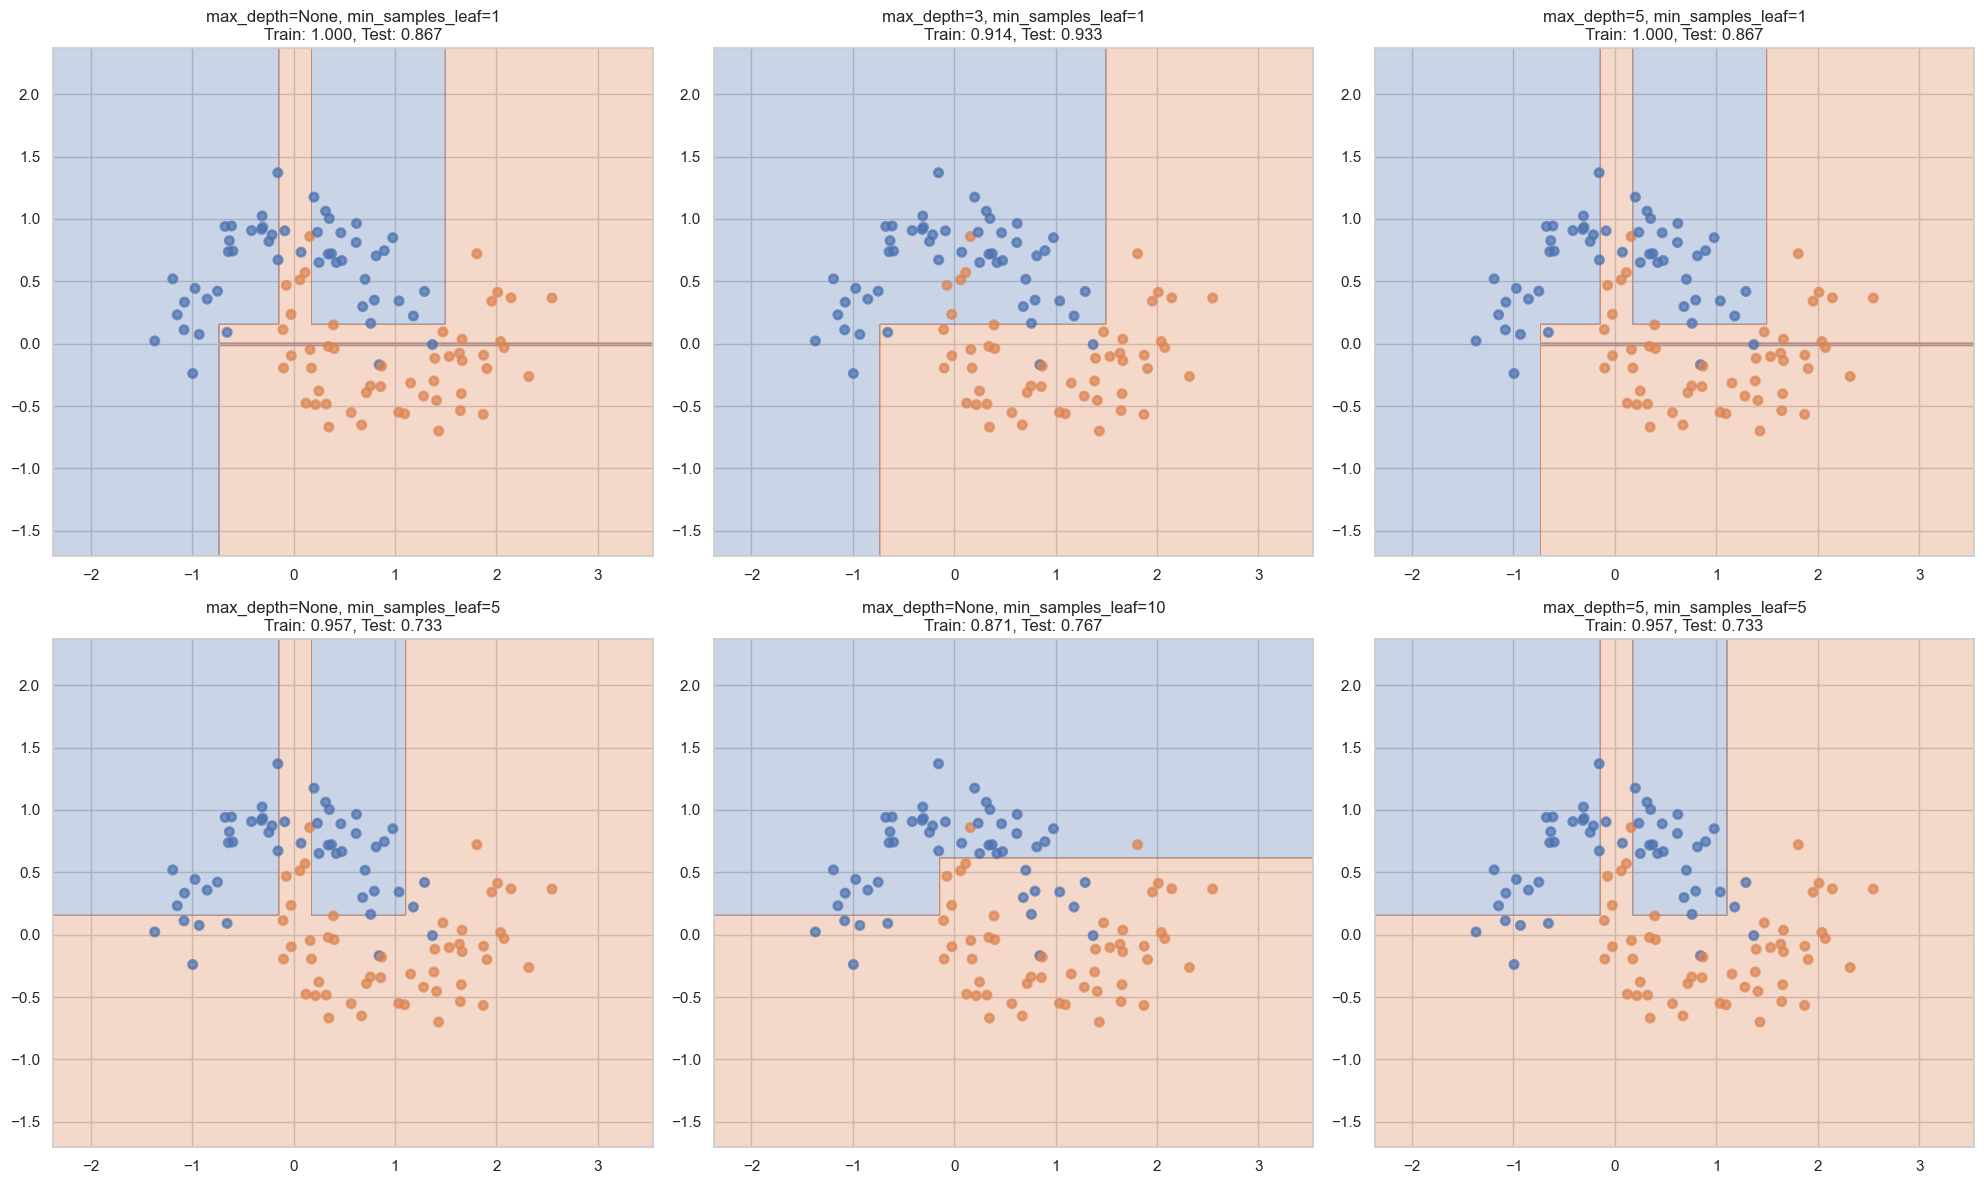


ДАТАСЕТ 3
Параметры: max_depth=None, min_samples_leaf=1
  Train accuracy: 1.000, Test accuracy: 0.833, Overfitting: 0.167
Параметры: max_depth=3, min_samples_leaf=1
  Train accuracy: 0.943, Test accuracy: 0.867, Overfitting: 0.076
Параметры: max_depth=5, min_samples_leaf=1
  Train accuracy: 0.971, Test accuracy: 0.800, Overfitting: 0.171
Параметры: max_depth=None, min_samples_leaf=5
  Train accuracy: 0.900, Test accuracy: 0.700, Overfitting: 0.200
Параметры: max_depth=None, min_samples_leaf=10
  Train accuracy: 0.886, Test accuracy: 0.767, Overfitting: 0.119
Параметры: max_depth=5, min_samples_leaf=5
  Train accuracy: 0.900, Test accuracy: 0.700, Overfitting: 0.200


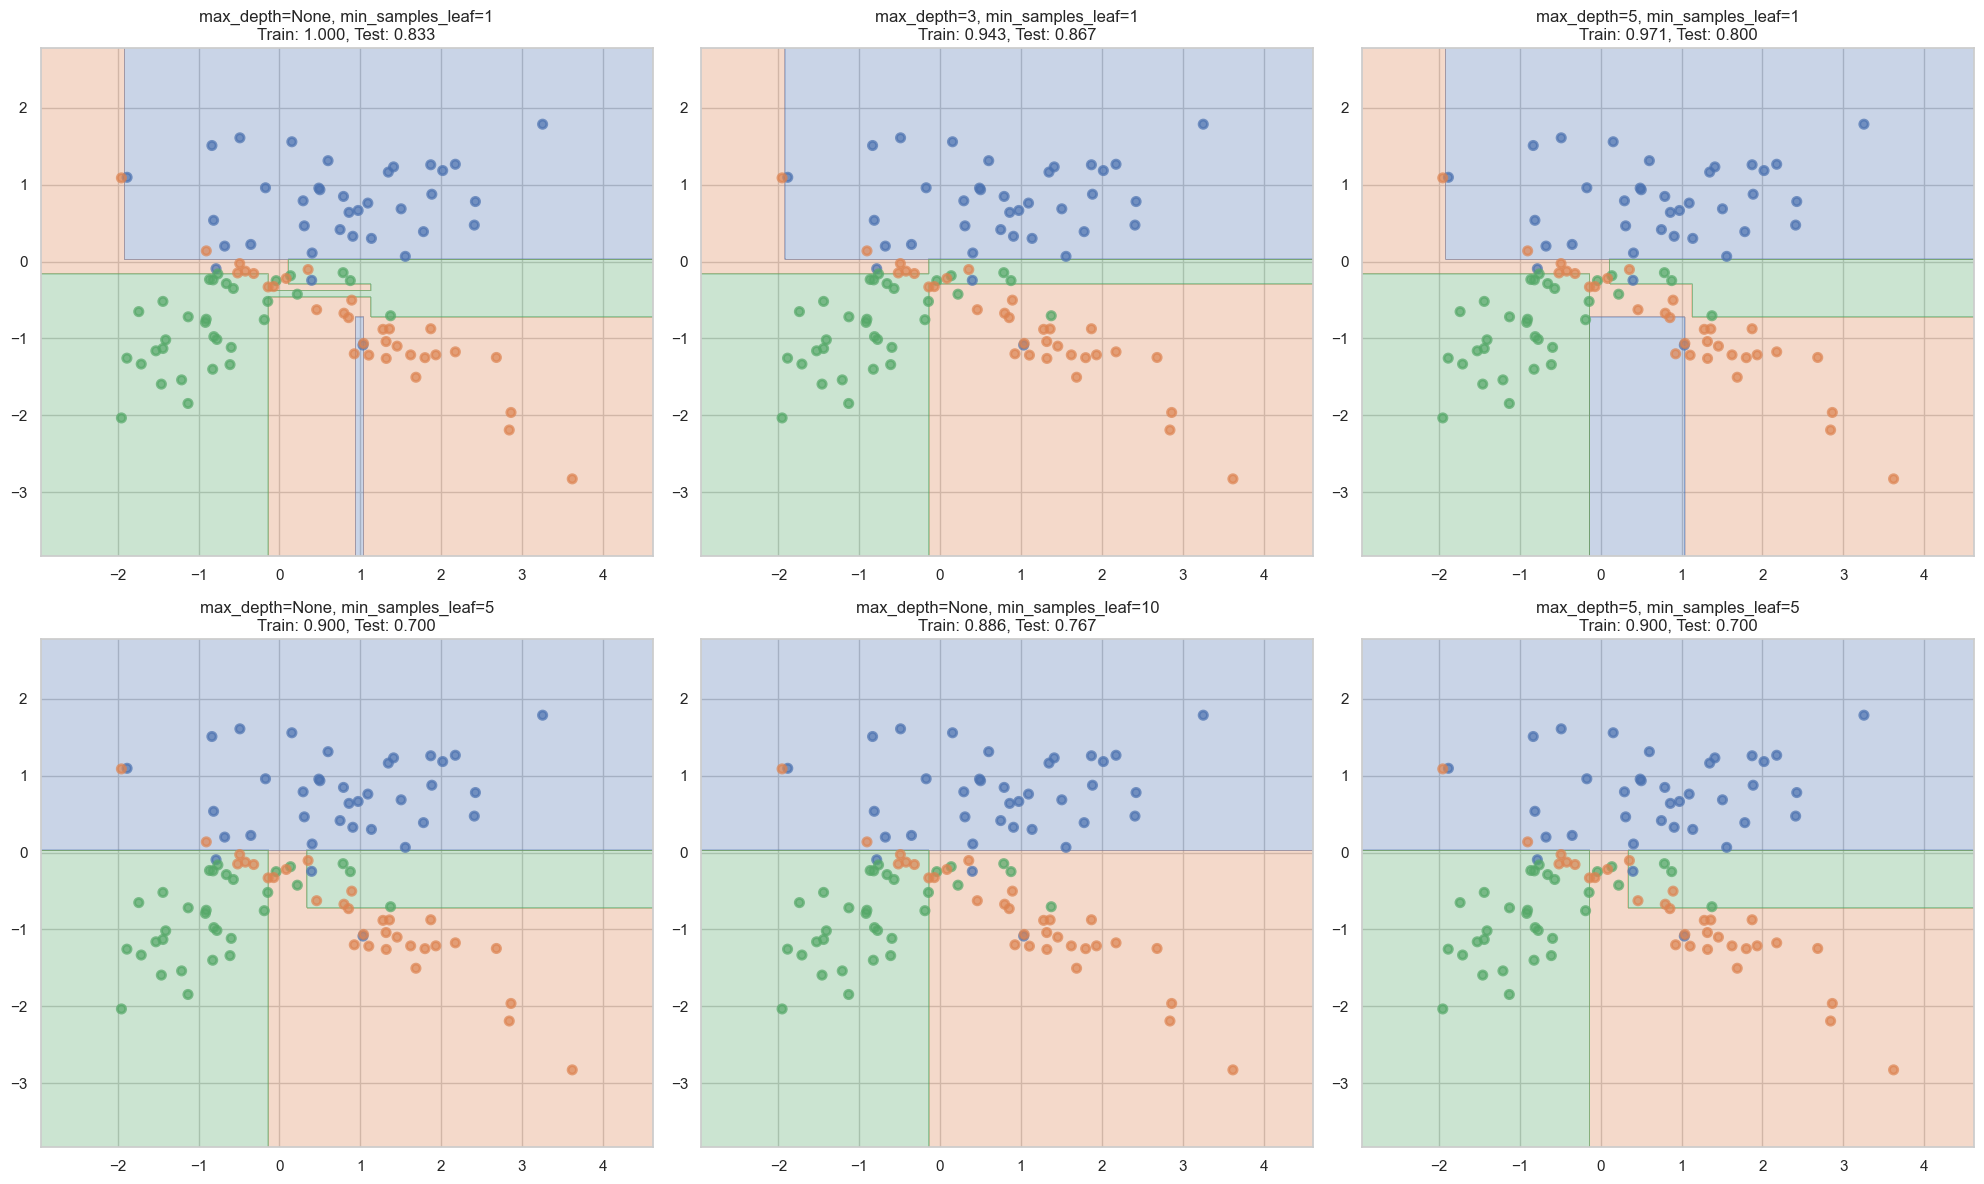

In [50]:
param_combinations = [
    {'max_depth': None, 'min_samples_leaf': 1},  
    {'max_depth': 3, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 1},
    {'max_depth': None, 'min_samples_leaf': 5},
    {'max_depth': None, 'min_samples_leaf': 10},
    {'max_depth': 5, 'min_samples_leaf': 5},
]

random_state = 42

for dataset_idx, (X, y) in enumerate(datasets, 1):
    print(f"\n{'='*50}")
    print(f"ДАТАСЕТ {dataset_idx}")
    print(f"{'='*50}")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state
    )
    
    plt.figure(figsize=(20, 12))
    
    for param_idx, params in enumerate(param_combinations, 1):

        clf = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=random_state
        )
        clf.fit(X_train, y_train)
        
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
    
        max_depth_str = params['max_depth'] if params['max_depth'] else 'None'
        print(f"Параметры: max_depth={max_depth_str}, min_samples_leaf={params['min_samples_leaf']}")
        print(f"  Train accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}, Overfitting: {train_acc - test_acc:.3f}")
    
        plt.subplot(2, 3, param_idx)
        plot_surface(clf, X, y)
        plt.title(f"max_depth={max_depth_str}, min_samples_leaf={params['min_samples_leaf']}\n"
                 f"Train: {train_acc:.3f}, Test: {test_acc:.3f}")
    
    
    plt.tight_layout()
    plt.show()


__Ответ:__
НЕТ, изменение разное для каждого датасета:

Dataset 1 (Circles):
Лучшая комбинация: max_depth=None, min_samples_leaf=5 или max_depth=5, min_samples_leaf=5

Результат: Test accuracy = 0.900

Особенность: Хорошо реагирует на min_samples_leaf

Dataset 2 (Moons):
Лучшая комбинация: max_depth=3, min_samples_leaf=1

Результат: Test accuracy = 0.933

Особенность: Предпочитает ограничение глубины, а не размера листьев

Dataset 3 (Classification):
Лучшая комбинация: max_depth=3, min_samples_leaf=1

Результат: Test accuracy = 0.867

Особенность: Сложнее всего поддается регуляризации

__Регуляризация эффективна, но ее воздействие сильно зависит от структуры данных.__

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

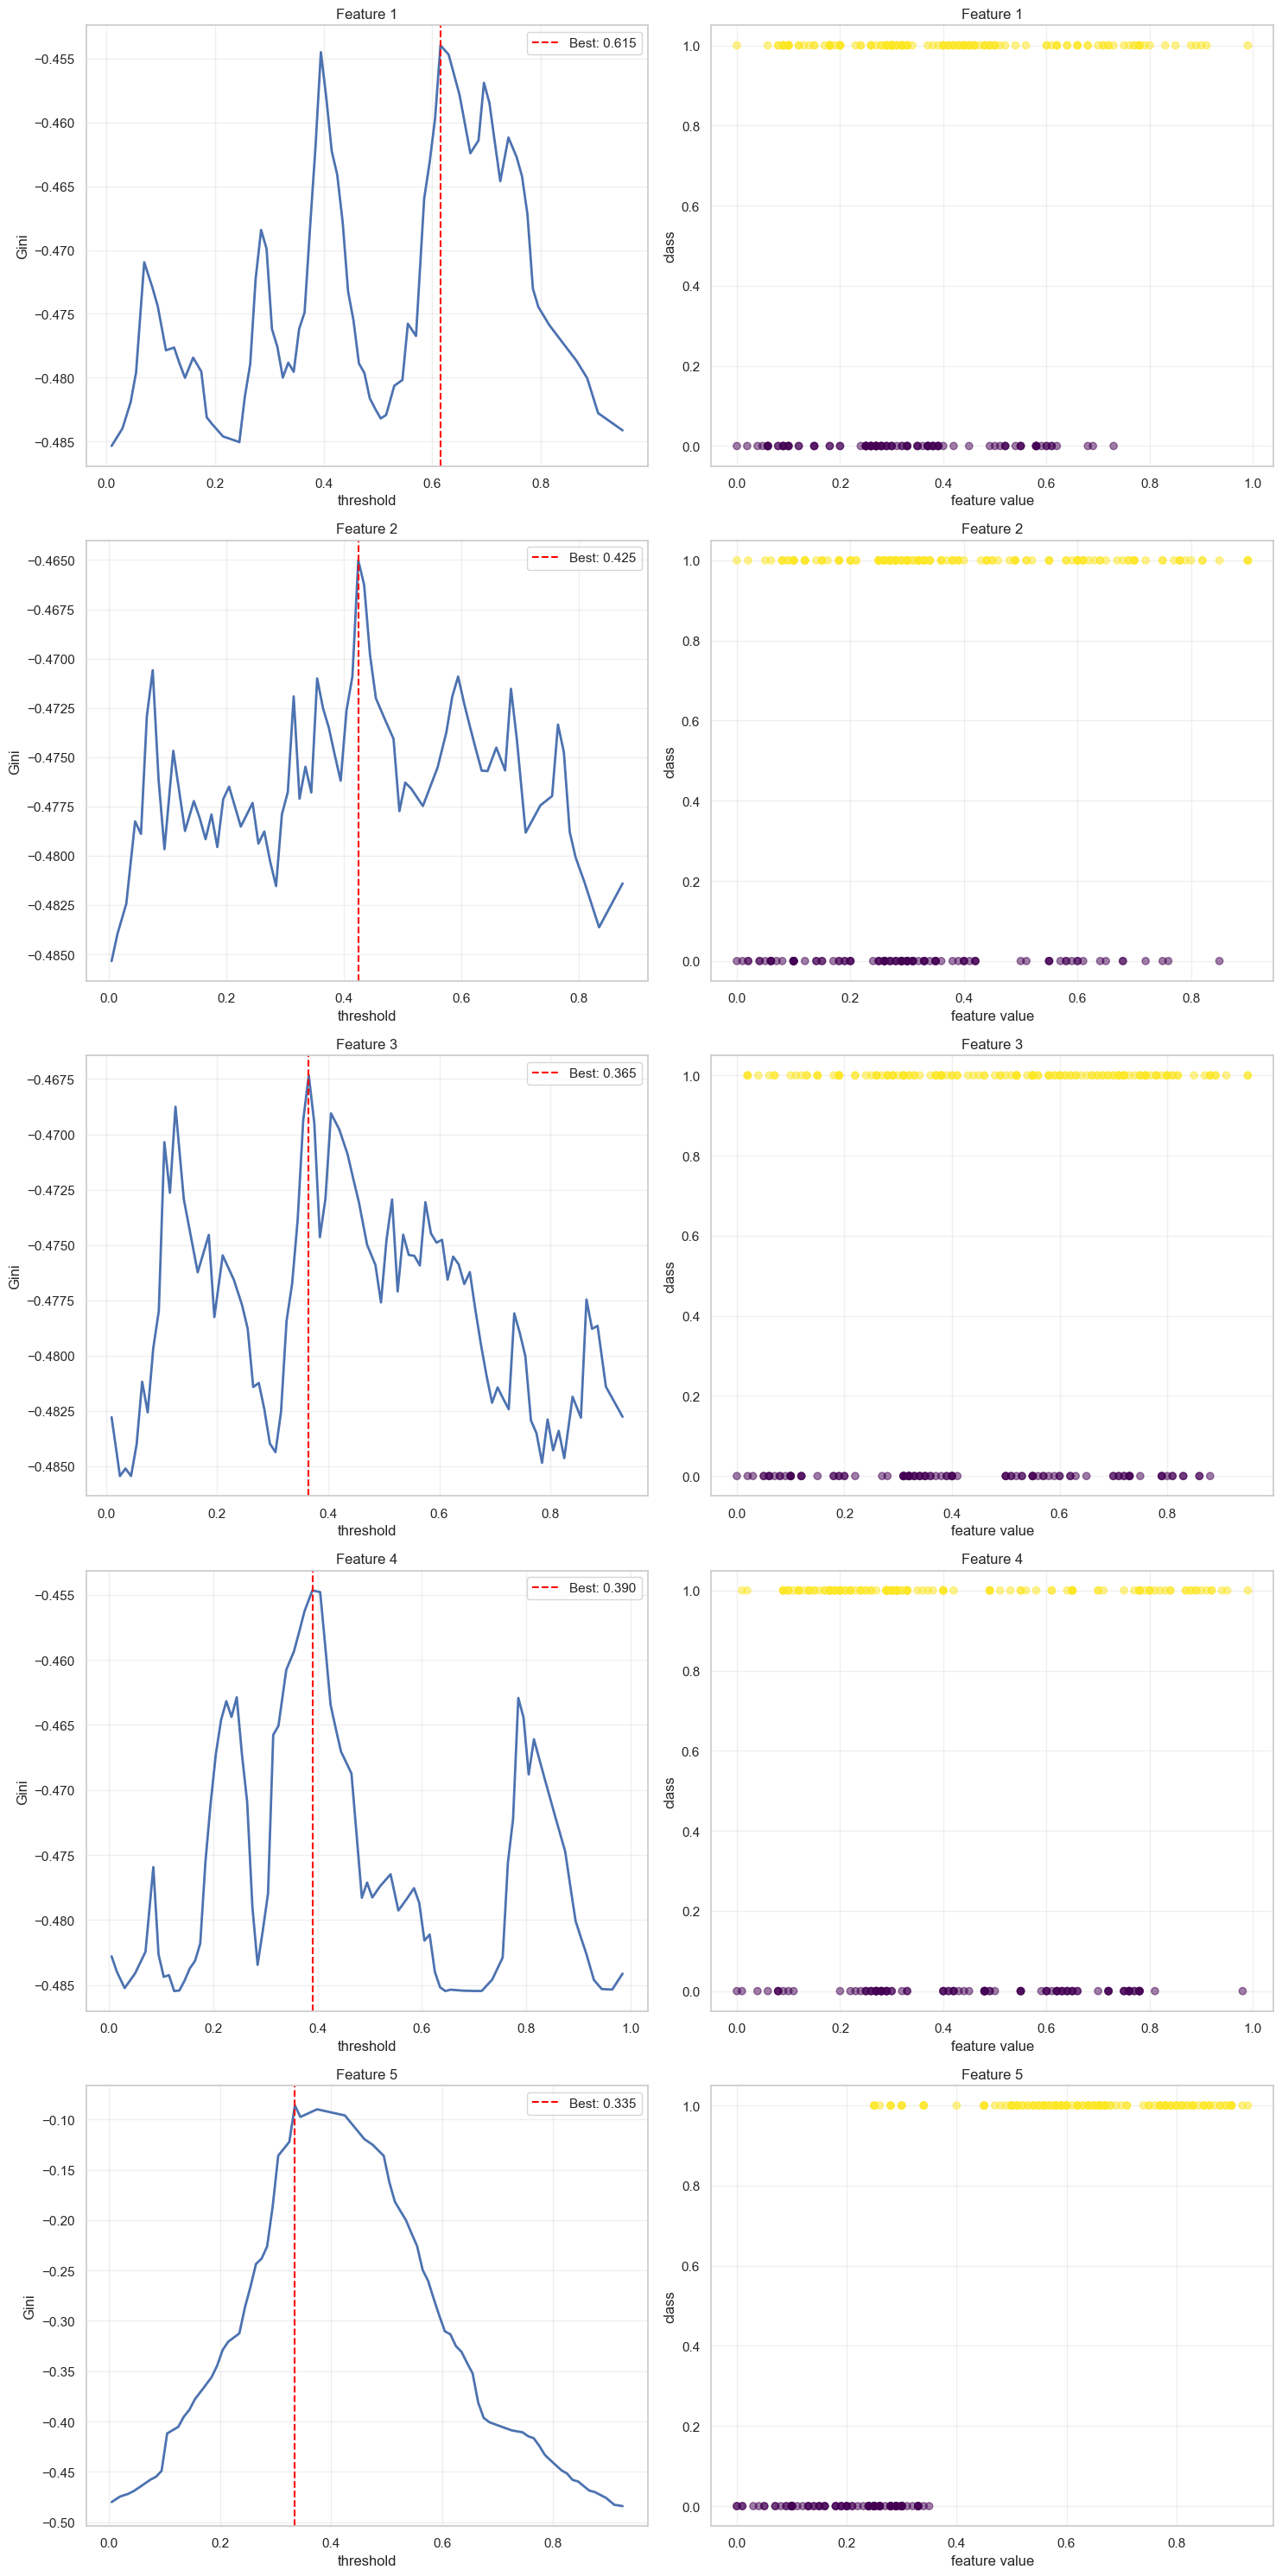

In [51]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

from hw2.hw2code import find_best_split

data = pd.read_csv("hw2/data/students.csv")
X = data.iloc[:, :5].values
y = data.iloc[:, -1].values

plt.figure(figsize=(15, 30))
num_features = 5

for i in range(num_features):

    plt.subplot(num_features, 2, 2 * i + 1)
    thresholds, ginis, best_threshold, best_gini = find_best_split(X[:, i], y)
    
    plt.plot(thresholds, ginis, 'b-', linewidth=2)
    if best_threshold is not None:
        plt.axvline(x=best_threshold, color='red', linestyle='--', 
                   label=f'Best: {best_threshold:.3f}')
        plt.legend()
    plt.title(f"Feature {i+1}")
    plt.xlabel("threshold")
    plt.ylabel("Gini")
    plt.grid(True, alpha=0.3)

    plt.subplot(num_features, 2, 2 * i + 2)
    plt.scatter(X[:, i], y, alpha=0.5, c=y, cmap='viridis')
    
    plt.title(f"Feature {i+1}")
    plt.xlabel("feature value")
    plt.ylabel("class")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Лучший признак для деления - Признак 5(PEG), потому что:

1. Наибольшее значение критерия Джини

2. Ярко выраженный пик на кривой Джини

2. Четкий порог разделения около 0.335

Согласование с scatter-графиками:
Да, полностью согласуется

Признак 5(PEG): На scatter видно четкое разделение

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [52]:
from hw2.hw2code import DecisionTree
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


data = pd.read_csv('hw2/data/agaricus-lepiota.data', header=None)

X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

le = LabelEncoder()
y = le.fit_transform(y)

for i in range(X.shape[1]):
    le = LabelEncoder()
    X[:, i] = le.fit_transform(X[:, i])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'Количество правильных предсказаний: {np.sum(y_pred == y_test)} из {len(y_test)}')

Accuracy: 1.0000
Количество правильных предсказаний: 4062 из 4062


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

Размерность данных: X_train (670, 9), X_test (288, 9)


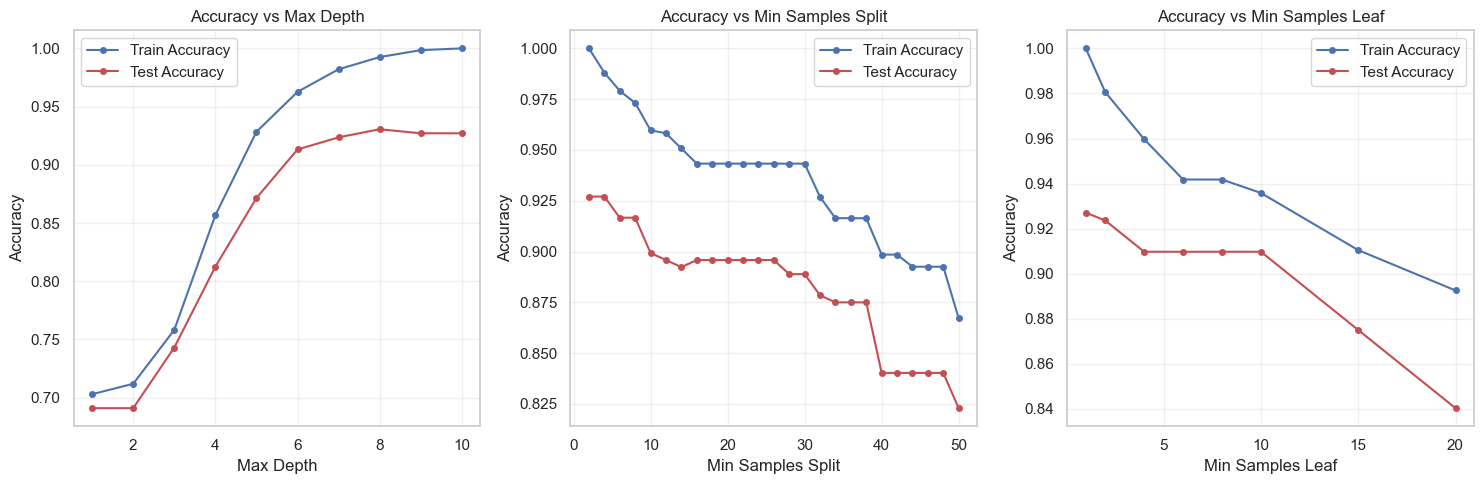


АНАЛИЗ РЕЗУЛЬТАТОВ
Лучший max_depth: 8
  Train Accuracy: 0.9925
  Test Accuracy:  0.9306

Лучший min_samples_split: 2
  Train Accuracy: 1.0000
  Test Accuracy:  0.9271

Лучший min_samples_leaf: 1
  Train Accuracy: 1.0000
  Test Accuracy:  0.9271

Переобучение (разница Train - Test):
  При max_depth=8: 0.0620
  При min_samples_split=2: 0.0729
  При min_samples_leaf=1: 0.0729


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Загрузка данных
df = pd.read_csv("hw2/data/tic-tac-toe-endgame.csv")

encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

X = df.iloc[:, :-1].values  
y = df.iloc[:, -1].values   

feature_types = ["categorical"] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
)

print(f"Размерность данных: X_train {X_train.shape}, X_test {X_test.shape}")

# Исследование зависимости качества от max_depth
max_depths = range(1, 11)
train_scores_depth = []
test_scores_depth = []

for depth in max_depths:
    tree = DecisionTree(feature_types=feature_types, max_depth=depth)
    tree.fit(X_train, y_train)
    
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_scores_depth.append(train_acc)
    test_scores_depth.append(test_acc)
    

# Исследование зависимости качества от min_samples_split
min_samples_splits = range(2, 51, 2)
train_scores_split = []
test_scores_split = []

for min_split in min_samples_splits:
    tree = DecisionTree(feature_types=feature_types, min_samples_split=min_split)
    tree.fit(X_train, y_train)
    
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_scores_split.append(train_acc)
    test_scores_split.append(test_acc)
    
 

# Исследование зависимости качества от min_samples_leaf
min_samples_leaves = [1, 2, 4, 6, 8, 10, 15, 20]
train_scores_leaf = []
test_scores_leaf = []

for min_leaf in min_samples_leaves:
    tree = DecisionTree(feature_types=feature_types, min_samples_leaf=min_leaf)
    tree.fit(X_train, y_train)
    
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    train_scores_leaf.append(train_acc)
    test_scores_leaf.append(test_acc)
 

# Построение графиков
plt.figure(figsize=(15, 5))

# График для max_depth
plt.subplot(1, 3, 1)
plt.plot(max_depths, train_scores_depth, 'b-', label='Train Accuracy', marker='o', markersize=4)
plt.plot(max_depths, test_scores_depth, 'r-', label='Test Accuracy', marker='o', markersize=4)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.grid(True, alpha=0.3)

# График для min_samples_split
plt.subplot(1, 3, 2)
plt.plot(min_samples_splits, train_scores_split, 'b-', label='Train Accuracy', marker='o', markersize=4)
plt.plot(min_samples_splits, test_scores_split, 'r-', label='Test Accuracy', marker='o', markersize=4)
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Split')
plt.legend()
plt.grid(True, alpha=0.3)

# График для min_samples_leaf
plt.subplot(1, 3, 3)
plt.plot(min_samples_leaves, train_scores_leaf, 'b-', label='Train Accuracy', marker='o', markersize=4)
plt.plot(min_samples_leaves, test_scores_leaf, 'r-', label='Test Accuracy', marker='o', markersize=4)
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min Samples Leaf')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ результатов
print("\n" + "="*50)
print("АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*50)

# Лучшие параметры для max_depth
best_depth_idx = np.argmax(test_scores_depth)
print(f"Лучший max_depth: {max_depths[best_depth_idx]}")
print(f"  Train Accuracy: {train_scores_depth[best_depth_idx]:.4f}")
print(f"  Test Accuracy:  {test_scores_depth[best_depth_idx]:.4f}")

# Лучшие параметры для min_samples_split
best_split_idx = np.argmax(test_scores_split)
print(f"\nЛучший min_samples_split: {min_samples_splits[best_split_idx]}")
print(f"  Train Accuracy: {train_scores_split[best_split_idx]:.4f}")
print(f"  Test Accuracy:  {test_scores_split[best_split_idx]:.4f}")

# Лучшие параметры для min_samples_leaf
best_leaf_idx = np.argmax(test_scores_leaf)
print(f"\nЛучший min_samples_leaf: {min_samples_leaves[best_leaf_idx]}")
print(f"  Train Accuracy: {train_scores_leaf[best_leaf_idx]:.4f}")
print(f"  Test Accuracy:  {test_scores_leaf[best_leaf_idx]:.4f}")

# Сравнение переобучения
print(f"\nПереобучение (разница Train - Test):")
print(f"  При max_depth={max_depths[best_depth_idx]}: {train_scores_depth[best_depth_idx] - test_scores_depth[best_depth_idx]:.4f}")
print(f"  При min_samples_split={min_samples_splits[best_split_idx]}: {train_scores_split[best_split_idx] - test_scores_split[best_split_idx]:.4f}")
print(f"  При min_samples_leaf={min_samples_leaves[best_leaf_idx]}: {train_scores_leaf[best_leaf_idx] - test_scores_leaf[best_leaf_idx]:.4f}")

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [54]:
from sklearn.preprocessing import OneHotEncoder

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# mushrums

mush = pd.read_csv("hw2/data/agaricus-lepiota.data", header=None)

encoders_mush = {}
for col in mush.columns:
    le = LabelEncoder()
    mush[col] = le.fit_transform(mush[col].astype(str))
    encoders_mush[col] = le

y_mush = mush.iloc[:, 0].values
X_mush = mush.iloc[:, 1:].values

# tic-tac-toe

xoxo = pd.read_csv("hw2/data/tic-tac-toe-endgame.csv")

encoders_xoxo = {}
for col in xoxo.columns:
    le = LabelEncoder()
    xoxo[col] = le.fit_transform(xoxo[col].astype(str))
    encoders_xoxo[col] = le

X_xoxo = xoxo.iloc[:, :-1].values
y_xoxo = xoxo.iloc[:, -1].values

# cars

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
cars = pd.read_csv(url, header=None)
encoders_cars_X = {}
for col in cars.columns[:-1]:
    le = LabelEncoder()
    cars[col] = le.fit_transform(cars[col].astype(str))
    encoders_cars_X[col] = le

y_cars_raw = cars.iloc[:, -1].astype(str).values

y_cars = np.where(np.isin(y_cars_raw, ["unacc", "acc"]), 0, 1)

X_cars = cars.iloc[:, :-1].values

# nurses

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
nur = pd.read_csv(url, header=None)

encoders_nur_X = {}
for col in nur.columns[:-1]:
    le = LabelEncoder()
    nur[col] = le.fit_transform(nur[col].astype(str))
    encoders_nur_X[col] = le

y_nur_raw = nur.iloc[:, -1].astype(str).values

y_nur = np.where(np.isin(y_nur_raw, ["not_recom", "recommend"]), 0, 1)

X_nur = nur.iloc[:, :-1].values

# datasets

datasets = {
    "mushrooms" : (X_mush, y_mush),
    "tic-tac-toe" : (X_xoxo, y_xoxo),
    "nursery" : (X_nur, y_nur),
    "cars" : (X_cars, y_cars)
}



In [55]:
from sklearn.model_selection import KFold
results = []
cv = KFold(n_splits=10, shuffle=True, random_state=42)

for name, (X, y) in datasets.items():
    print("Processing:", name)

    # Для хранения accuracy по фолдам
    acc_real_list = []
    acc_cat_list = []
    acc_ohe_list = []
    acc_sklearn_list = []

    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # 1. DecisionTree, считающий все признаки вещественными
        clf_real = DecisionTree(feature_types=["real"] * X.shape[1])
        clf_real.fit(X_train, y_train)
        y_pred_real = clf_real.predict(X_test)
        acc_real_list.append(accuracy_score(y_test, y_pred_real))

        # 2. DecisionTree, считающий все признаки категориальными
        clf_cat = DecisionTree(feature_types=["categorical"] * X.shape[1])
        clf_cat.fit(X_train, y_train)
        y_pred_cat = clf_cat.predict(X_test)
        acc_cat_list.append(accuracy_score(y_test, y_pred_cat))

        # 3. One-Hot Encoding + вещественные признаки
        try:
            ohe = OneHotEncoder(sparse_output=False)
        except TypeError:
            ohe = OneHotEncoder()
        
        X_train_ohe = ohe.fit_transform(X_train)
        X_test_ohe = ohe.transform(X_test)
        
        # Если получили sparse matrix, преобразуем в dense
        if hasattr(X_train_ohe, 'toarray'):
            X_train_ohe = X_train_ohe.toarray()
            X_test_ohe = X_test_ohe.toarray()
            
        clf_ohe = DecisionTree(feature_types=["real"] * X_train_ohe.shape[1])
        clf_ohe.fit(X_train_ohe, y_train)
        y_pred_ohe = clf_ohe.predict(X_test_ohe)
        acc_ohe_list.append(accuracy_score(y_test, y_pred_ohe))

        # 4. Sklearn DecisionTreeClassifier
        clf_sklearn = DecisionTreeClassifier(random_state=42)
        clf_sklearn.fit(X_train, y_train)
        y_pred_sklearn = clf_sklearn.predict(X_test)
        acc_sklearn_list.append(accuracy_score(y_test, y_pred_sklearn))

    # Усредняем результаты по фолдам
    acc_real = np.mean(acc_real_list)
    acc_cat = np.mean(acc_cat_list)
    acc_ohe = np.mean(acc_ohe_list)
    acc_sklearn = np.mean(acc_sklearn_list)

    results.append([name, acc_real, acc_cat, acc_ohe, acc_sklearn])

# Создаем DataFrame
columns = [
    "dataset",
    "my_tree_real", 
    "my_tree_categorical",
    "my_tree_onehot",
    "sklearn_tree"
]

df_results = pd.DataFrame(results, columns=columns)

print(df_results.to_string(index=False, float_format='%.6f'))

Processing: mushrooms
Processing: tic-tac-toe
Processing: nursery
Processing: cars
    dataset  my_tree_real  my_tree_categorical  my_tree_onehot  sklearn_tree
  mushrooms      1.000000             1.000000        1.000000      1.000000
tic-tac-toe      0.877873             0.944715        0.944715      0.890351
    nursery      0.999769             0.999769        0.999769      0.999691
       cars      0.990163             0.987273        0.987851      0.990741


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
Эффективность зависит от природы данных - нет универсального лучшего подхода

Категориальные методы лучше, когда категории имеют сложные взаимоотношения

Вещественные методы могут выигрывать, когда случайно захватывают порядковые отношения

One-Hot кодирование не всегда оптимально - создает разреженность и теряет информацию о взаимосвязях категорий


Для категориальных данных стоит тестировать оба подхода (вещественный и категориальный), так как их эффективность непредсказуема и зависит от скрытой структуры данных.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [56]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ